## Snakes and Ladders

In [193]:
#import section - use the abstract Markov Process class from rl directory
from rl.markov_process import MarkovProcess, FiniteMarkovProcess
from rl.markov_process import Transition, FiniteMarkovRewardProcess, RewardTransition
from rl.distribution import Categorical, Constant
from typing import Dict, Tuple
import numpy as np
import itertools
import matplotlib.pyplot as plt

#### As Markov Process (Problem 1)
Observations:
1. State Space = {all integers from 0 to 100}, inclusive;
2. The current state is all it needs to determine the next state - satisfying markov property;
3. Every one state have equal probability of moving to one of the six possible next states, considering snakes and ladders;
4. Players back up if they cannot exactly hit the 100.

Therefore the following need special attention:
1. A dictionary of snakes and ladders, which maps from A to B, with snakes having A > B and ladders having A < B;
2. Snakes and ladders cannot be possibly placed at the exact starting point. Likewise, two snakes or two ladders cannot be possibly placed at the exact starting point. Use key in dictionary to guarantee uniqueness;
3. 100 is the terminal state. To model back up, map 99 to one of {100,99,98,97,96,95}.

Thus, the class (in general) will possibly need:
1. N - A range of states, practically at least 2. In the example game N = 100. To avoid going on forever, set maxN = 100. Any user-provided N > 100 will be set to 100;
2. A dictionary setting snakes and ladders. Key = starting point and Value = ending point. Starting point can be one of the non-terminal states excluding 0. Ending point can be one of the states excluding 0. 
3. Initializer should set member variables and do sanity check.

Formal answer:
1. State space: {0,1,...,N}/{starting points of snakes or ladders}, non-terminal space: {0,1,...,N-1}/{starting points of snakes or ladders}. 
2. Each state can reach another six states with equal probability.

In [194]:
class SnakesAndLaddersMP(MarkovProcess[int]):
    
    def __init__(self, N : int, snakeladder : Dict[int, int]):
        
        if N > 100:
            self.N : int = 100
        else:
            self.N : int = N
            
        for key, value in snakeladder.items():
            if key <=0 or key  >= self.N:
                print("Key %d does not satisfy requirement."%(key))
                raise
            if value<=0 or value > self.N:
                print("Value %d does not satisfy requirement."%(value))
                raise
        
        self.snakeladder = snakeladder
    
    def transition(self, state : int) -> Categorical[int]:
        
        if state < 0 or state > self.N:
            print("State %d not in range."%(state))
            raise
            
        if state in self.snakeladder.keys():
            print("State %d not possible."%(state))
            raise
            
        if state == self.N:
            return None
        
        next_state : Dict[int, Categorical[int]] = {}
        
        for i in range(1,7):
            if (state + i) in self.snakeladder:
                next_state[self.snakeladder[state+i]] = 1./6.
            elif (state + i) > self.N:
                new_state : int = 2*self.N-state-i
                if new_state in self.snakeladder and self.snakeladder[new_state] in next_state:
                    next_state[self.snakeladder[new_state]] += 1./6.
                elif new_state in self.snakeladder:
                    next_state[self.snakeladder[new_state]] = 1./6.
                elif new_state in next_state:
                    next_state[new_state] += 1./6.
                else:
                    next_state[new_state] = 1./6.
            else:
                next_state[state+i] = 1./6.
            
        return Categorical(next_state)

In [195]:
# Test with the website's example:
snake_ladder : Dict[int,int] = {1:38,4:14,9:31,16:6,21:42,36:44,47:26,49:11,51:67,56:53,
                                62:19,64:60,71:91,80:100,87:24,93:73,95:75,98:78}

GameBoard = SnakesAndLaddersMP(N = 100, snakeladder = snake_ladder)

print(GameBoard.transition(0).table())
print(GameBoard.transition(97).table())

{38: 0.16666666666666669, 2: 0.16666666666666669, 3: 0.16666666666666669, 14: 0.16666666666666669, 5: 0.16666666666666669, 6: 0.16666666666666669}
{78: 0.33333333333333337, 99: 0.33333333333333337, 100: 0.16666666666666669, 97: 0.16666666666666669}


#### As Finite Markov Process (Problem 2)

In [196]:
class SnakesAndLaddersFMP(FiniteMarkovProcess[int]):
    
    def __init__(self, N : int, snakeladder : Dict[int, int]):
        
        self.mp = SnakesAndLaddersMP(N = N,snakeladder = snakeladder)
        super().__init__(self.get_transition_map())
        
    def get_transition_map(self) -> Transition[int]:
        
        trans_map: Dict[int, Categorical[int]] = {}
        for i in range(self.mp.N+1):
            if i in self.mp.snakeladder.keys():
                continue
            trans_map[i] = self.mp.transition(i)
        
        return trans_map

In [197]:
def snakesandladder_endtime(N : int, snakeladder : Dict[int, int],
                            num_traces: int, maxround: int) -> np.array:
    GameBoard = SnakesAndLaddersFMP(N = N, snakeladder = snakeladder)
    start_state_dis = Constant(0)
    return np.array([np.fromiter(
        itertools.islice(GameBoard.simulate(start_state_dis),maxround),int).shape[0] 
        for _ in range(num_traces)])

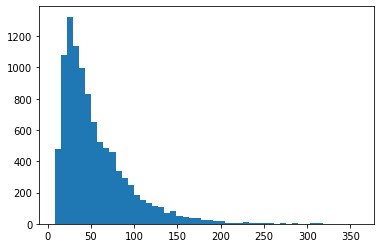

In [198]:
# Test with the website's example:
snake_ladder = {1:38,4:14,9:31,16:6,21:42,36:44,47:26,49:11,51:67,56:53,62:19,64:60,
                71:91,80:100,87:24,93:73,95:75,98:78}

endtime = snakesandladder_endtime_pdf(N = 100, snakeladder = snake_ladder, 
                                      num_traces = 10000, maxround = 1000000)

_ = plt.hist(endtime,bins = 50)

#### As Finite Markov Reward Process (Problem 4)

In [199]:
class SnakesAndLaddersFMRP(FiniteMarkovRewardProcess[int]):
    
    def __init__(self, N : int, snakeladder : Dict[int, int]):
                
        self.fmp = SnakesAndLaddersFMP(N = N, snakeladder = snakeladder)
        super().__init__(self.get_transition_reward_map())
        
    def get_transition_reward_map(self) -> RewardTransition[int]:
        
        trans_map: Dict[int, Categorical[Tuple[int,int]]] = {}            
        for i in range(self.fmp.mp.N+1):
            if i in self.fmp.mp.snakeladder.keys():
                continue
            
            if i == self.fmp.mp.N:
                trans_map[i] = None
                continue
        
            next_sr : Categorical[Tuple[int,int]] = \
                {(k,1):v for k,v in self.fmp.mp.transition(i).table().items()}                    
            trans_map[i] = Categorical(next_sr)                    
        
        return trans_map

In [200]:
# Test with the website's example:
snake_ladder = {1:38,4:14,9:31,16:6,21:42,36:44,47:26,49:11,51:67,56:53,62:19,64:60,
                71:91,80:100,87:24,93:73,95:75,98:78}

GameBoard = SnakesAndLaddersFMRP(N = 100, snakeladder = snake_ladder)

print("Expected number of dice rolls using FMRP: %.4f" 
      %(GameBoard.get_value_function_vec(gamma = 1)[0]))
print("Expected number of dice rolls using simulation from FMP: %.4f"
      %(np.mean(endtime)))

Expected number of dice rolls using FMRP: 54.1685
Expected number of dice rolls using simulation from FMP: 54.8552
